Problem 1: Boosting

For Boosting machine, we are always working on the residuals. That is we trained a sequence of weak classifiers, but together they become a strong classifiers. The idea is that each time we learn a weak classifier, then we store the residual, which is how much we classified wrong at that time. Then we fixed the classifiers that we already learned, and take the residual as our data for the next iteration. Then we train another classifier base on the residuals, and repeat the process again. Though this is a very lazy algorithm and we fixed the parameters we learned without any update, it actually help to prevent over-fitting, and when combine these weak classifiers, they become a powerful one.

The intuition behind this boosting algorithm is to alter the pattern in residuals and produce a weak classifier at that iteration, until our residuals become randomly distributed. Once we reach a stage that residuals do not have any pattern that could be further altered, we can stop modeling residuals. That is we minimize the loss function, such that test loss reaches minima.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2 + 1e-7)

In [ ]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [ ]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

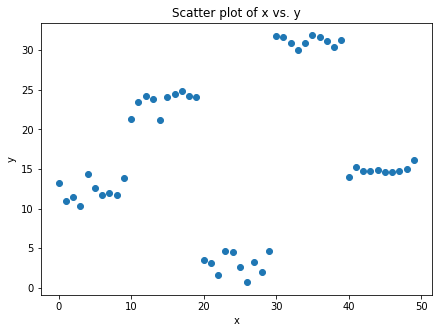

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

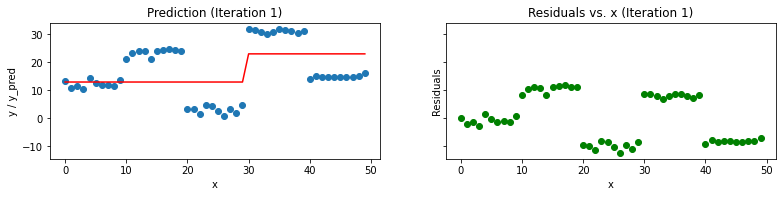

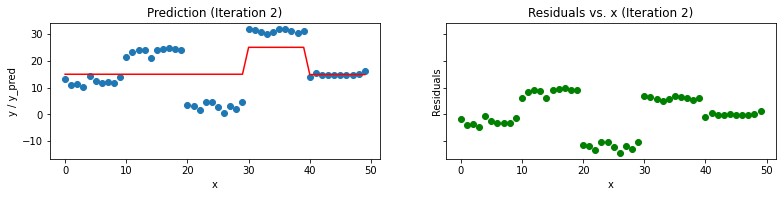

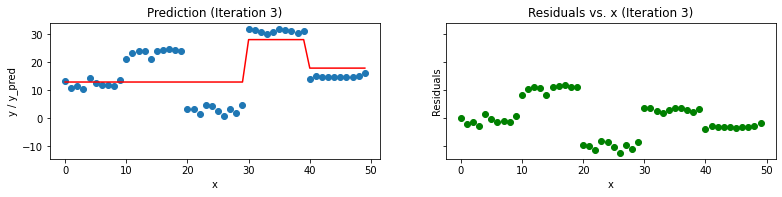

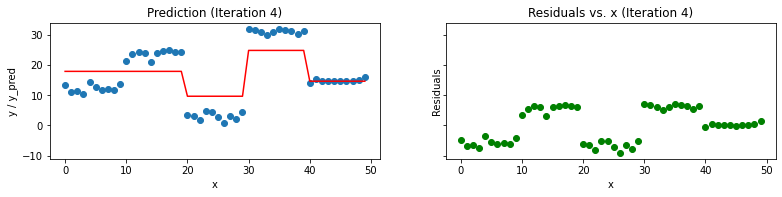

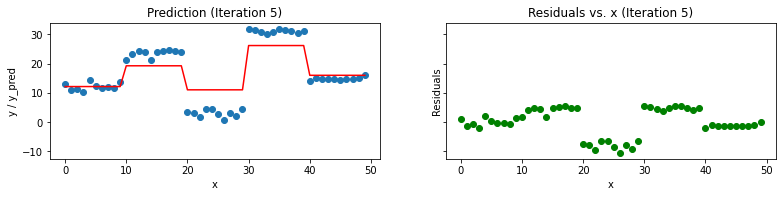

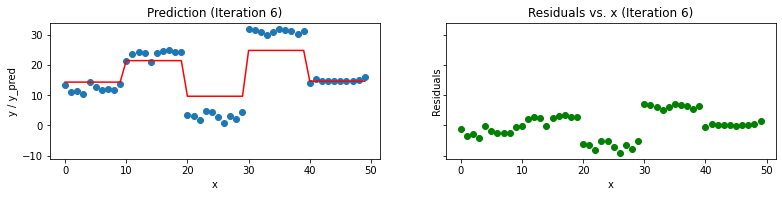

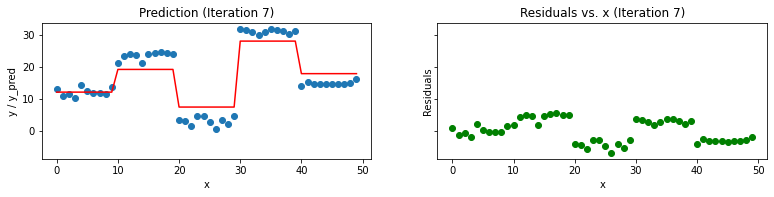

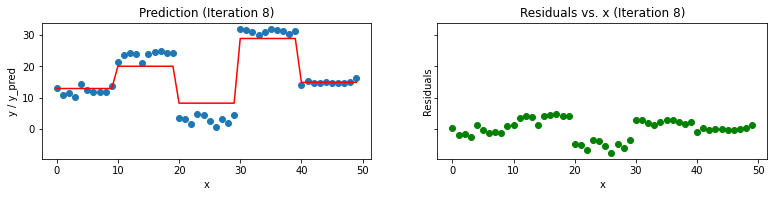

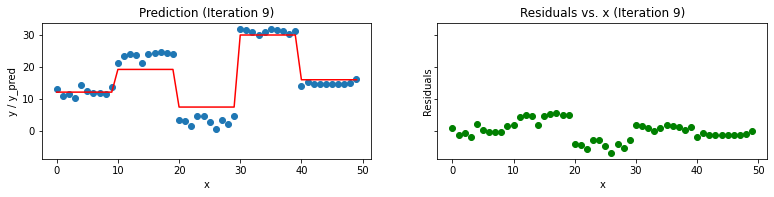

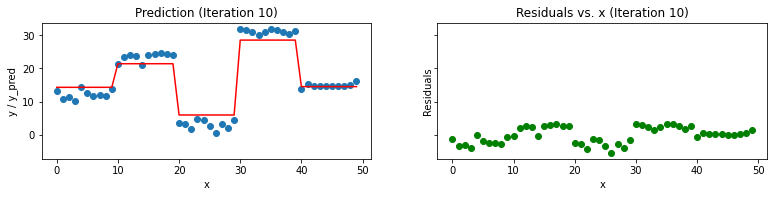

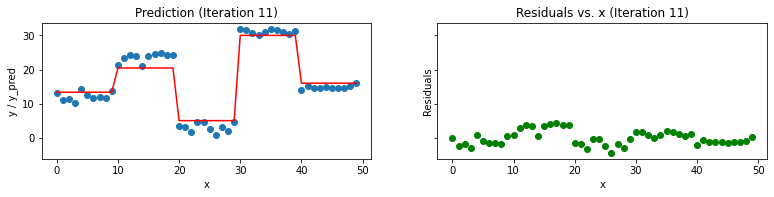

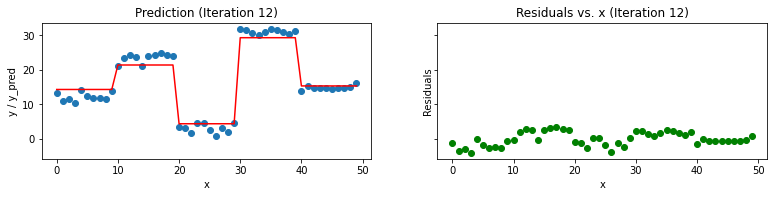

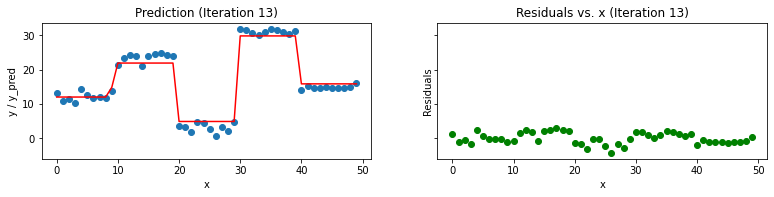

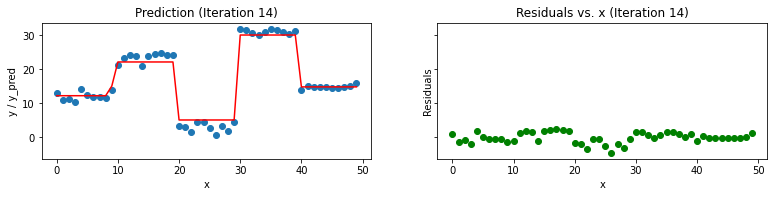

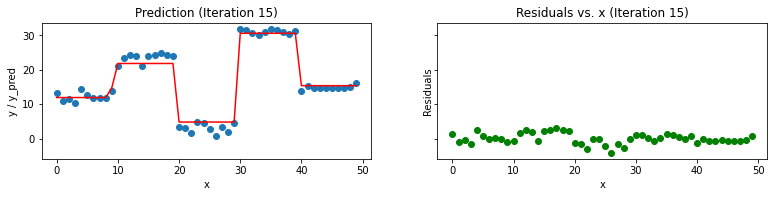

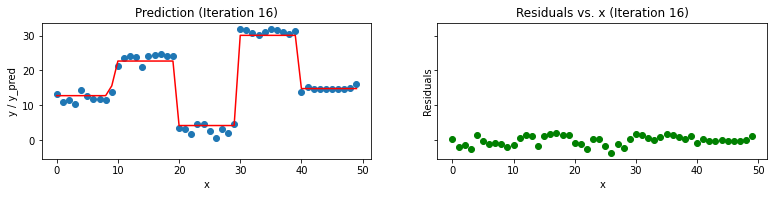

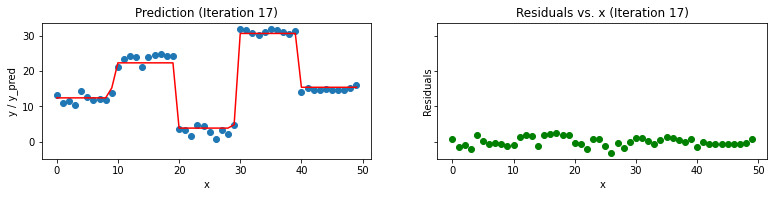

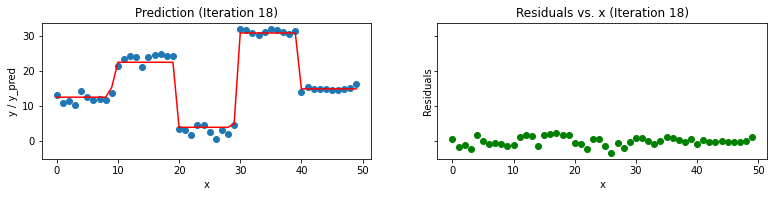

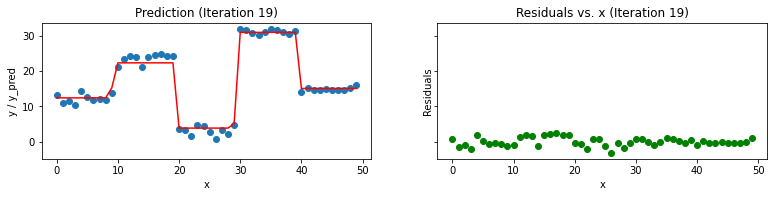

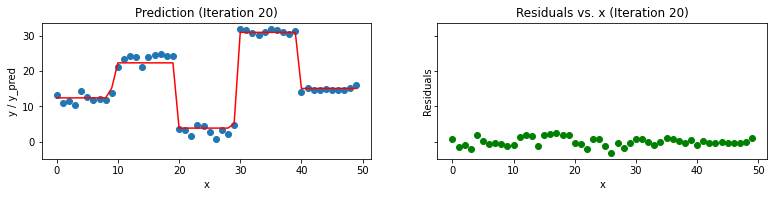

In [ ]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(20): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')

Below we train on the spam email classification problem. Here we try a list of different parameters to find the best set of parameters that will return the highest testing accuracy. We use 2 different parameters here: (1) min_impurity_decrease on a log scale, and (2) number of tree in the boosting model. Here, we print out the testing and training accuracy for each combination of the paramters. As can be see from the output, the best log_min_impurity_decrease is -3 and the best number of trees = 17. The training error = 0.91 and the testing error = 0.88. The accuracy for all of the different combination is shown in the plot.

###############################################
log_min_impurity = -3
number of trees =  1
training accuracy = 0.9067934782608695
testing accuracy = 0.8921195652173914
###############################################
log_min_impurity = -3
number of trees =  5
training accuracy = 0.9141304347826086
testing accuracy = 0.8945652173913043
###############################################
log_min_impurity = -3
number of trees =  9
training accuracy = 0.9166440217391305
testing accuracy = 0.8970108695652174
###############################################
log_min_impurity = -3
number of trees =  13
training accuracy = 0.9162364130434784
testing accuracy = 0.8975543478260869
###############################################
log_min_impurity = -3
number of trees =  17
training accuracy = 0.9165760869565218
testing accuracy = 0.8978260869565217
###############################################
log_min_impurity = -2
number of trees =  1
training accuracy = 0.8861413043478261
testing accuracy = 0.8798913

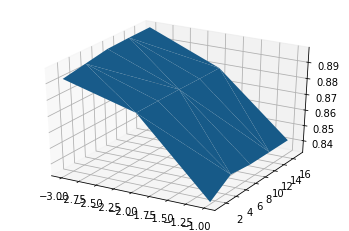

training acc:  0.9089673913043478
testing acc:  0.8881650380021715


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import copy

def load_data():
	# load data 
	data = pd.read_csv(
		'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
	p_ = data.shape[1]
	p = p_ - 1
	X = data.iloc[:, :p]
	y = data.iloc[:, p]

	# split the data to training set and testing test
	# the training set will be used to choose hyperparameters
	X_train, X_test, y_train, y_test = train_test_split(
		X, y, test_size=0.2, random_state=0)
	return X_train.values, X_test.values, y_train.values, y_test.values


class XGBOOST():
	def __init__(self, min_impurity_decrease=0.01, M=5):
		self.min_impurity_decrease = min_impurity_decrease
		self.M = M
		self.step = 1e-1
		self.Trees = []
		self.Gamma = 0.0

	def fit(self, train_features, train_labels):
		n = train_features.shape[0]
		min_loss = 1e7
		for gamma in self.step*np.arange(0,1/self.step):
			gamma_array = gamma*np.ones(n)
			loss = log_loss(train_labels, gamma_array)
			if loss < min_loss:
				min_loss = loss
				F0 = gamma
		
		old_F = copy.deepcopy(F0)
		self.Gamma = F0
		
		for i in range(self.M):
			r = train_labels/old_F-(1-train_labels)/(1-old_F)
			self.Trees.append(DecisionTreeRegressor(random_state=0, min_impurity_decrease = self.min_impurity_decrease))
			self.Trees[i].fit(train_features, r)
			h = self.Trees[i].predict(train_features)
			old_F = old_F+h
			
		# compute accuracy
		acc = 1-np.mean(np.abs((old_F>0.5).astype(float)-train_labels))
		return acc

	def scoring(self, test_features, test_labels):
		n = test_features.shape[0]
		F = self.Gamma
		for i in range(self.M):
			h = self.Trees[i].predict(test_features)
			F += h
			
		acc = 1-np.mean(np.abs((F>0.5).astype(float)-test_labels))
		return acc

#########################################################

# define a function to do cross-validation to search for hyperparameter values with training set
def cross_validation(log_min_impurity_decreases, Ms, n_splits=5):
	# log_min_impurity_decreases: a list consists of min_impurity_decrease on a log scale
	# Ms: a list consists of the number of trees that a boosting model has
	# n_splits: the folds for cross-validation
	# the purpose of the function is to tune in min_impurity_decrease and M

	# this function returns three objects:
	# 1. plot_values is a numpy.array where the first column is log_min_impurity_decrease
	# , the second column is M, and the third column is the corresponding mean accuracy
	# 2. best_log_min_impurity_decrease: the best log_min_impurity_decrease
	# 3. best_M: the best M
	# 2. and 3. are determined by the highest average accuracy

	#########################################################
	kf = KFold(n_splits)
	plot_values = np.zeros((len(log_min_impurity_decreases)*len(Ms), 3))
	cnt = 0
	best_acc = 0.0
	best_log_min_impurity_decrease = 1e7
	best_M = 1e7
	for i in log_min_impurity_decreases:
		impurity = np.e**i
		for M in Ms:
			train_acc = 0
			test_acc = 0
			
			for train_index, test_index in kf.split(X_train):
				model = XGBOOST(impurity, M)
				train_acc += model.fit(X_train[train_index,:], y_train[train_index])
				test_acc += model.scoring(X_train[test_index], y_train[test_index])
      
			train_acc /= n_splits
			test_acc /= n_splits

			print('###############################################')
			print('log_min_impurity =', i)
			print('number of trees = ', M)
			print('training accuracy =', train_acc)
			print('testing accuracy =', test_acc)      

			if test_acc > best_acc:
				best_acc = test_acc
				best_log_min_impurity_decrease = i
				best_M = M
			
			plot_values[cnt][0] = i
			plot_values[cnt][1] = M
			plot_values[cnt][2] = test_acc
			
			cnt += 1
	
	#########################################################
	return plot_values, best_log_min_impurity_decrease, best_M



def run_XGBOOST(log_min_impurity_decreases,Ms):

	X_train, X_test, y_train, y_test = load_data()
	
	plot_values, best_log_min_impurity_decrease, best_M = cross_validation(log_min_impurity_decreases=log_min_impurity_decreases, Ms=Ms)
	print('##################################################')
	print('best_log_min_impurity_decrease: ',best_log_min_impurity_decrease)
	print('best number of trees: ',best_M)

	# plot the accuracy over the hyperparameter values
	fig = plt.figure()
	ax = fig.gca(projection='3d')
	ax.plot_trisurf(plot_values[:, 0], plot_values[:, 1], plot_values[:, 2], linewidth=0.2, antialiased=True)
	plt.show()

	model = XGBOOST(np.e**best_log_min_impurity_decrease, best_M)
	acc = model.fit(X_train, y_train)
	print("training acc: ", acc)
	acc = model.scoring(X_test, y_test)
	print("testing acc: ", acc)


if __name__=="__main__":

	X_train, X_test, y_train, y_test = load_data()
 
	#XGboost
	log_min_impurity_decreases = list(range(-3, 0))
	Ms = list(range(1,20,4))
	run_XGBOOST(log_min_impurity_decreases,Ms)

